# Modelos de regresión

## Librerias utilizadas

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

## Preparar y combinar datos

In [24]:
def cargarData():
  orders = pd.read_csv("../data_clean/olist_orders_dataset_clean.csv")
  orderItems = pd.read_csv("../data_clean/olist_order_items_dataset_clean.csv")
  products = pd.read_csv("../data_clean/olist_products_dataset_clean.csv")
  sellers = pd.read_csv("../data_clean/olist_sellers_dataset_clean.csv")
  customers = pd.read_csv("../data_clean/olist_customers_dataset_clean.csv")
  payments = pd.read_csv("../data_clean/olist_order_payments_dataset_clean.csv")
  reviews = pd.read_csv("../data_clean/olist_order_reviews_dataset_clean.csv")
  
  df = orders.merge(orderItems, on="order_id", how="left")\
              .merge(products, on="product_id", how="left")\
              .merge(sellers, on="seller_id", how="left")\
              .merge(customers, on="customer_id", how="left")\
              .merge(payments, on="order_id", how="left")\
              .merge(reviews, on="order_id", how="left")
  
  df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
  df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
  df['delivery_diff_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
  df = df[df['delivery_diff_days'].notnull()]
  
  return df

## Separar features (X) y target (y)

In [25]:
def prepararVariables(df):
  selectedFeatures = [
      'price', 'freight_value', 'product_weight_g', 
      'product_length_cm', 'product_height_cm', 'product_width_cm', 
      'customer_state', 'seller_state', 'review_score', 'payment_value'
  ]
  
  df = pd.get_dummies(df, columns=['customer_state', 'seller_state'], drop_first=True)
  
  X = df[[col for col in df.columns if col in selectedFeatures or col.startswith('customer_state_') or col.startswith('seller_state_')]]
  y = df['delivery_diff_days']
  
  return train_test_split(X, y, test_size=0.2, random_state=42)

## Regresión lineal

In [26]:
def entrenarRegresionLineal(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)

  print("R^2 Score:", r2)
  print("MSE:", mse)
  
  return model, X_test, y_test, y_pred

### Graficar resultados

In [27]:
def graficarDiagnostico(y_test, y_pred):
  residuals = y_test - y_pred
  
  # Real vs Predicho
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
  plt.xlabel("Valores Reales (días de retraso)")
  plt.ylabel("Valores Predichos")
  plt.title("Dispersión: Valores Reales vs Predichos")
  plt.axline((0, 0), slope=1, color='red', linestyle='--')
  plt.tight_layout()
  plt.show()
  
  # Histograma de residuos
  plt.figure(figsize=(7,5))
  sns.histplot(residuals, bins=50, kde=True)
  plt.xlabel("Error (residuo)")
  plt.title("Distribución de Errores (Residuos)")
  plt.tight_layout()
  plt.show()
  
  # Residuos vs Predicción
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Valores Predichos")
  plt.ylabel("Errores (residuos)")
  plt.title("Errores vs Predicción")
  plt.tight_layout()
  plt.show()

In [28]:
def mainRegresionLineal():
  # Cargar y preparar los datos
  df = cargarData()
  XTrain, XTest, yTrain, yTest = prepararVariables(df)

  # Entrenar el modelo de regresión lineal
  model, X_test, y_test, y_pred = entrenarRegresionLineal(XTrain, yTrain)

  # Graficar el diagnóstico del modelo
  graficarDiagnostico(y_test, y_pred)

## Regresión XGBoost

### Entrenar XGBoost

In [29]:
def entrenarXgboost(XTrain, yTrain):
  model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
  model.fit(XTrain, yTrain)
  return model

### Evaluar el modelo

In [ ]:
def evaluarModelo(model, XTest, yTest):
  yPred = model.predict(XTest)
  r2 = r2_score(yTest, yPred)
  mse = mean_squared_error(yTest, yPred)
  print(f"R^2 Score: {r2}")
  print(f"MSE: {mse}")
  return yPred

### Graficar resultados

In [31]:
def graficarResultados(yTest, yPred):
  residuals = yTest - yPred

  # Dispersión real vs predicho
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=yTest, y=yPred, alpha=0.3)
  plt.xlabel("Valores Reales (días de retraso)")
  plt.ylabel("Valores Predichos")
  plt.title("Dispersión: Valores Reales vs Predichos")
  plt.axline((0, 0), slope=1, color='red', linestyle='--')
  plt.tight_layout()
  plt.show()

  # Histograma de residuos
  plt.figure(figsize=(7,5))
  sns.histplot(residuals, bins=50, kde=True)
  plt.xlabel("Error (residuo)")
  plt.title("Distribución de Errores (Residuos)")
  plt.tight_layout()
  plt.show()

  # Errores vs Predicción
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=yPred, y=residuals, alpha=0.3)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Valores Predichos")
  plt.ylabel("Errores (residuos)")
  plt.title("Errores vs Predicción")
  plt.tight_layout()
  plt.show()

In [32]:
def mainXgboost():
  df = cargarData()
  XTrain, XTest, yTrain, yTest = prepararVariables(df)
  model = entrenarXgboost(XTrain, yTrain)
  yPred = evaluarModelo(model, XTest, yTest)
  graficarResultados(yTest, yPred)

## Aplicar modelos de regresión y resultados

In [33]:
def main():
  # Llamada al main de regresión lineal
  print("Ejecutando regresión lineal...")
  mainRegresionLineal()
  
  # Llamada al main de XGBoost
  print("Ejecutando XGBoost...")
  mainXgboost()

Ejecutando regresión lineal...
R^2 Score: 0.07627364303183004
MSE: 96.45055191138155


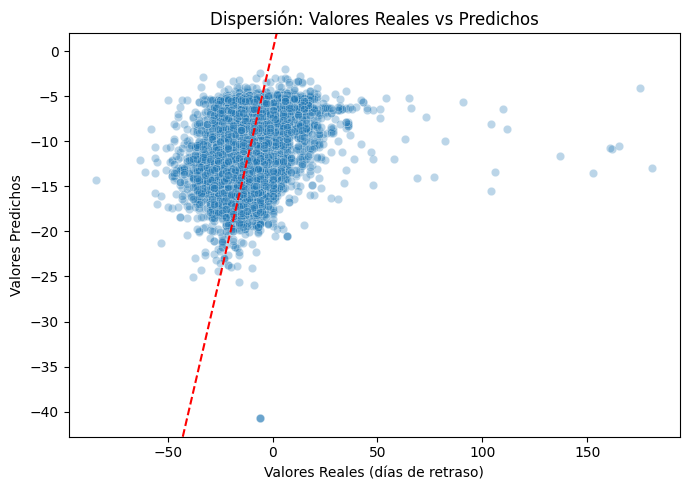

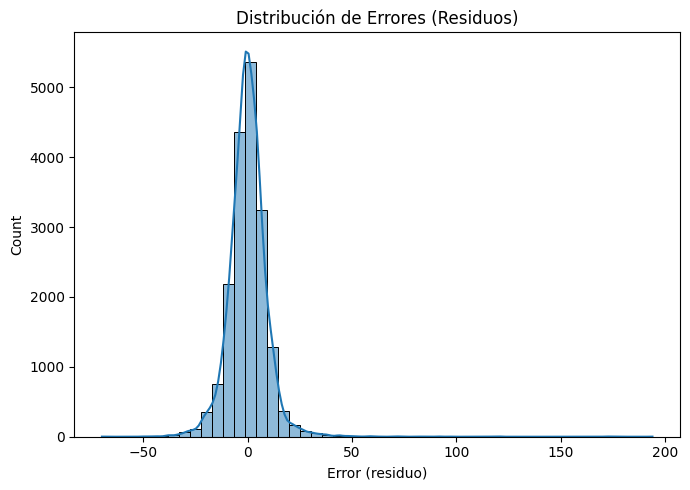

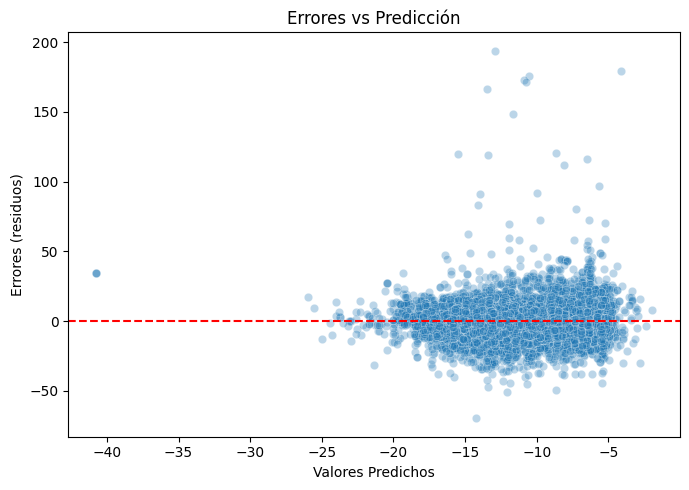

Ejecutando XGBoost...
R² Score: 0.16507256031036377
MSE: 87.89414978027344


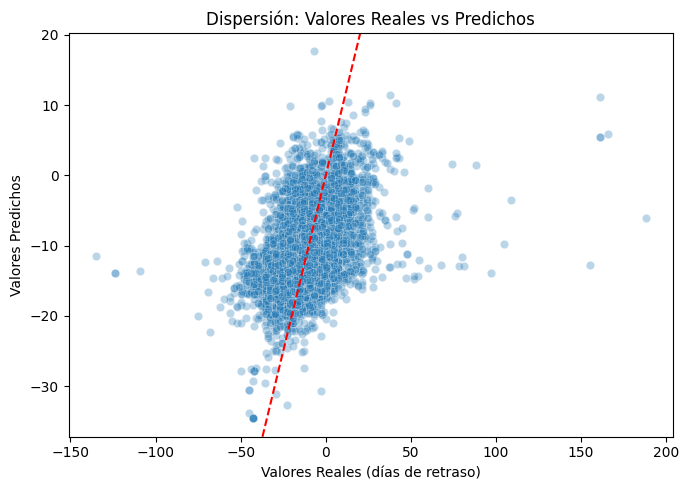

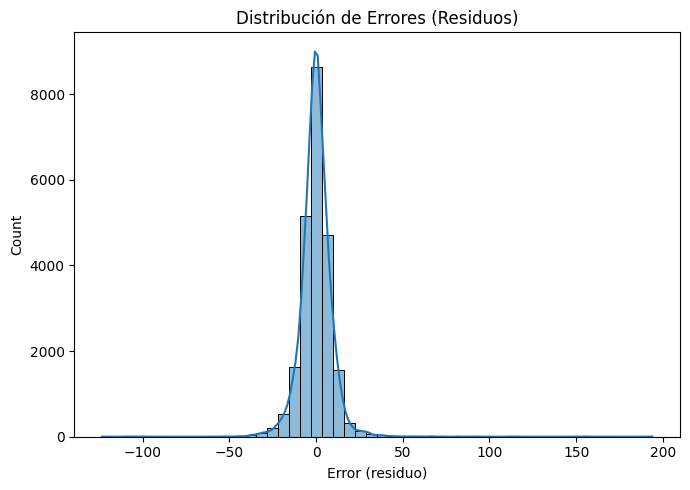

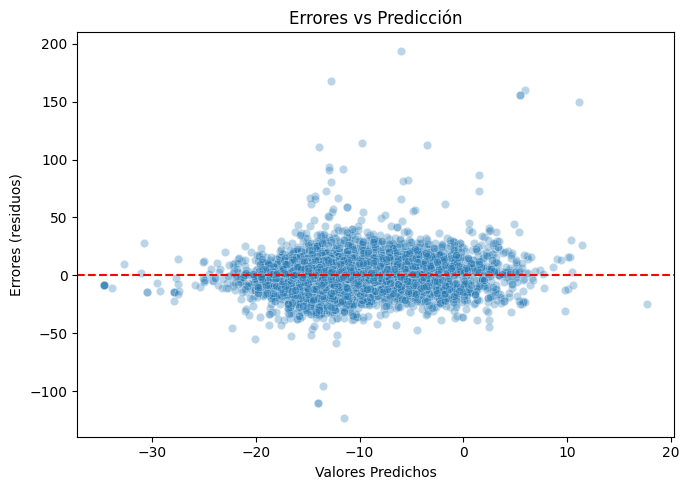

In [34]:
main()